In [1]:
!pip install -q transformers datasets evaluate segments-ai
!apt-get install git-lfs
!git lfs install
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 7.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not up

In [2]:
from segments import SegmentsClient
from getpass import getpass

api_key = getpass('Enter your API key: ')
segments_client = SegmentsClient(api_key)

Enter your API key: ··········


In [3]:
from segments.huggingface import release2dataset

release_name = 'v0.1'
dataset_identifier = 'jjasonzhang/fish_open_wounds'

release = segments_client.get_release(dataset_identifier, release_name)
hf_dataset = release2dataset(release)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [4]:
from segments.utils import get_semantic_bitmap

def convert_segmentation_bitmap(example):
    return {
        "label.segmentation_bitmap":
            get_semantic_bitmap(
                example["label.segmentation_bitmap"],
                example["label.annotations"],
                id_increment=0,
            )
    }


semantic_dataset = hf_dataset.map(
    convert_segmentation_bitmap,
)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [5]:
semantic_dataset = semantic_dataset.rename_column('image', 'pixel_values')
semantic_dataset = semantic_dataset.rename_column('label.segmentation_bitmap', 'label')
semantic_dataset = semantic_dataset.remove_columns(['name', 'uuid', 'status', 'label.annotations'])

In [6]:
hf_dataset_identifier = "jjasonzhang/fish_open_wounds"

semantic_dataset.push_to_hub(hf_dataset_identifier)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/321 [00:00<?, ?B/s]

In [7]:
from datasets import load_dataset

ds = load_dataset(hf_dataset_identifier)

Generating train split:   0%|          | 0/25 [00:00<?, ? examples/s]

In [8]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

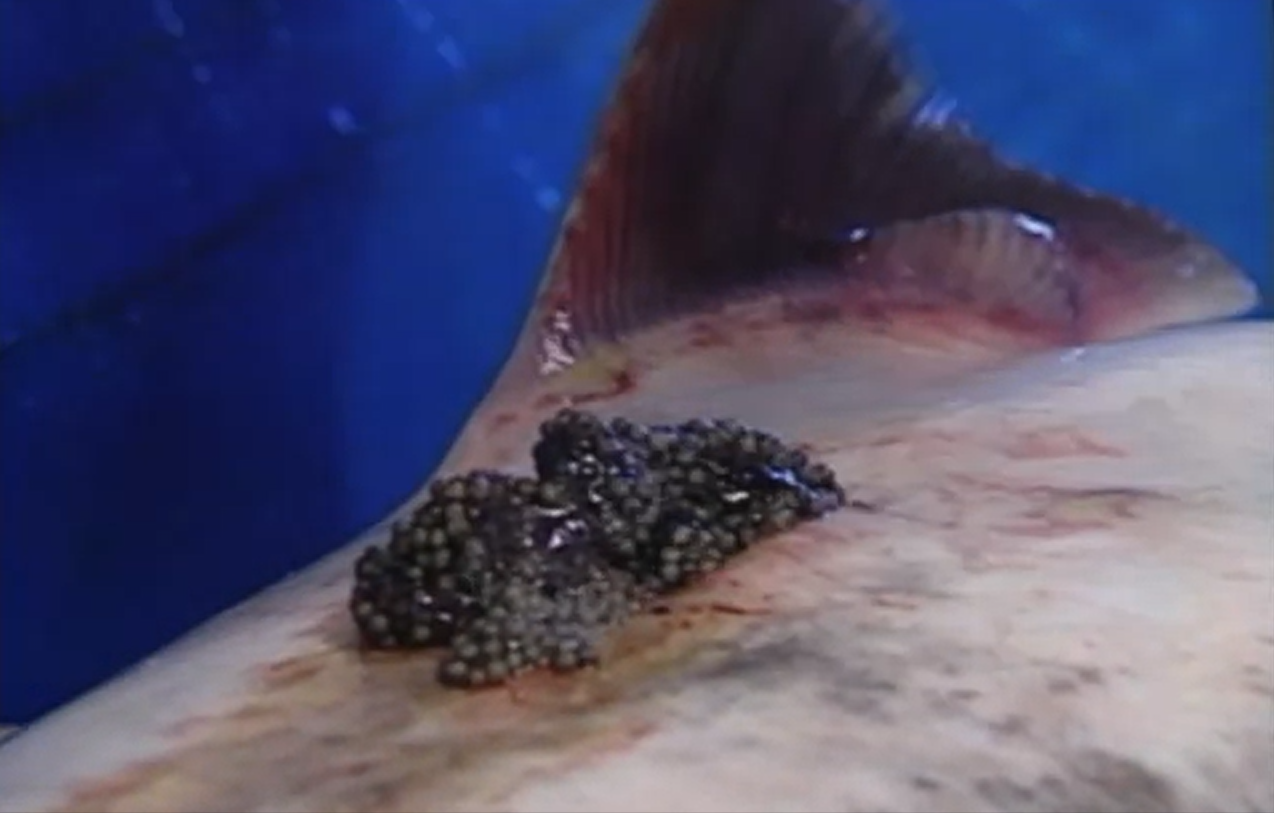

In [9]:
import numpy as np
from PIL import Image

idx = 10

# load image
image = ds["train"][idx]
image['pixel_values']

(-0.5, 1273.5, 812.5, -0.5)

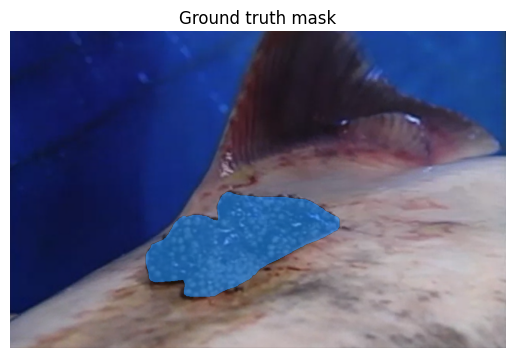

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image['pixel_values']))
ground_truth_seg = np.array(image["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [11]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [37]:
import torch.nn.functional as F
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["pixel_values"].convert("RGB")
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    pad_height1 = max(1300 - ground_truth_mask.shape[0], 0)
    pad_width1 = max(1300 - ground_truth_mask.shape[1], 0)

    padded_mask = np.pad(ground_truth_mask, ((0, pad_height1), (0, pad_width1)), mode='constant')

    # add ground truth segmentation
    inputs["ground_truth_mask"] = padded_mask

    return inputs

In [38]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [39]:
dataset = load_dataset("jjasonzhang/fish_open_wounds", split="train")

In [40]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [41]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (1300, 1300)


In [42]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [43]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 1300, 1300])


In [44]:
batch["ground_truth_mask"].shape

torch.Size([2, 1300, 1300])

In [64]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [65]:
!pip install monai-generative

In [66]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [87]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      predicted_masks = F.interpolate(predicted_masks,
                size=(1300, 1300),
                mode='bilinear',
                align_corners=False)

      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


EPOCH: 0
Mean loss: 0.3929180617515857


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


EPOCH: 1
Mean loss: 0.318373170036536


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


EPOCH: 2
Mean loss: 0.2964392052246974


100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


EPOCH: 3
Mean loss: 0.27601964657123274


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]

EPOCH: 4
Mean loss: 0.2538876195366566


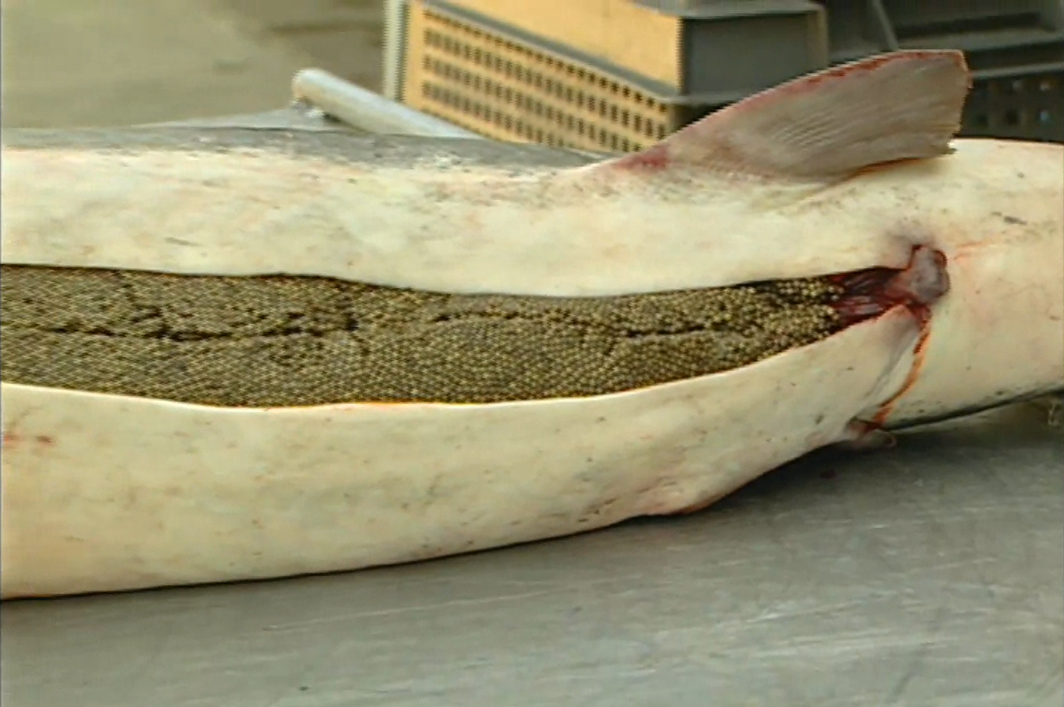

In [114]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 3

# load image
image = ds["train"][idx]["pixel_values"]
image

In [115]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

print(type(image))

image = image.convert("RGB")

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

for k,v in inputs.items():
  print(k,v.shape)

<class 'PIL.PngImagePlugin.PngImageFile'>
pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [116]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [117]:
# apply sigmoid
seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
seg_prob = seg_prob.cpu().numpy().squeeze()
seg = (seg_prob > 0.5).astype(np.uint8)

In [125]:
import cv2
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

(-0.5, 1299.5, 1299.5, -0.5)

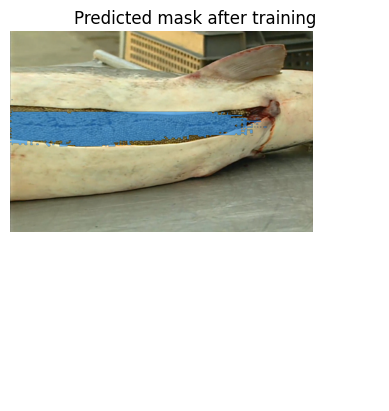

In [123]:
seg = cv2.resize(seg, (1300, 1300), interpolation=cv2.INTER_LINEAR)
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(seg, axes)
axes.title.set_text(f"Predicted mask after training")
axes.axis("off")

(-0.5, 1063.5, 708.5, -0.5)

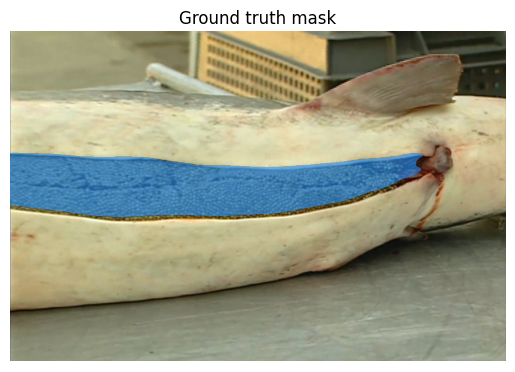

In [122]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")